In [2]:
%load_ext autoreload
%autoreload 2

In [108]:
from collections import Counter
import glob
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
def set_seaborn_style():
    # Idk why we have to call this twice for it to work but... here we are
    sns.set(rc={'figure.figsize':(8,5)})
    sns.set_theme(style="whitegrid")
set_seaborn_style()
import nltk
from gensim.models import Word2Vec
import joblib
from tqdm import tqdm
tqdm.pandas()

import hptutil

In [306]:
global_window_high = 21
global_window_low = 9
global_epochs = 80
global_min_count = 10
global_seed = 1948
fig_path = os.path.join("..","figs")

In [307]:
token_sets = [
    ["black","colored","n*****","nigger","niggers","negro","negros","negroes","blacks"],
    ["child","children","childs","chillun"],
    ["coop","coops"],
    ["field","fields"],
    #["free"]
    ["house","houses"],
    ["man","men","mans"],
    ["master","marster","masters","marsters","marse",'massa'],
    #["quarters","quarter","coop","coops"],
    ["slave","slaves"],
    ["white","whites"],
    ["woman","women"],
    ["exslave","exslaves"],
    ["slavery","slavry"],
    ['darky', 'darkey'],
    ['thing','ting'],
    ['have', 'hab'],
    ['live', 'lib'],
    ['was', 'wus'],
    ['folk', 'folks'],
]
token_map = {}
for cur_token_set in token_sets:
    first_token = cur_token_set[0]
    for cur_other_token in cur_token_set[1:]:
        token_map[cur_other_token] = first_token
token_map

{'colored': 'black',
 'n*****': 'black',
 'nigger': 'black',
 'niggers': 'black',
 'negro': 'black',
 'negros': 'black',
 'negroes': 'black',
 'blacks': 'black',
 'children': 'child',
 'childs': 'child',
 'chillun': 'child',
 'coops': 'coop',
 'fields': 'field',
 'houses': 'house',
 'men': 'man',
 'mans': 'man',
 'marster': 'master',
 'masters': 'master',
 'marsters': 'master',
 'marse': 'master',
 'massa': 'master',
 'slaves': 'slave',
 'whites': 'white',
 'women': 'woman',
 'exslaves': 'exslave',
 'slavry': 'slavery',
 'darkey': 'darky',
 'ting': 'thing',
 'hab': 'have',
 'lib': 'live',
 'wus': 'was'}

In [308]:
stopwords_en = nltk.corpus.stopwords.words('english')
stopwords_custom = [
    # Alphabetical
    'abc', 'ah', 'ai', 'around', 'atter', 'aw', 'can', 'come', 'dar', 'dat', 'day', 'de', "dey", 'em', 'er',
    'every', 'fa', 'far',
    'go', 'got', 'jes', 'know', 'move',
    'n', 'none', 'nt',
    'oh', 'old', 'ole', 'p', 'say', 'see', 'still', 'tell', 'th', 'time', 'try',
    'us', 'uv', 'uz', 'w', "war", 'would', 'wuz', 'year', 'yo', 'yuh',
    '$', '_',
    # Unordered
    'make', 'never', 'take', 'could', 'bout', 'live', 'en', 'wid', 'big', 'back',
    'dem', 'give', 'place', 'ter', 'bear', 'get', 'like', 'little', 'do', 'use', 'long',
    'well', 'den', 'two', 'dere', 'way', 'thing', 'much', 'put', 'ge', 'uh',
    'call', 'git', 'run', 'keep', 'cause', 'think', 'remember', 'wus',
    'look', 'away', 'let', 'yes', 'many', 'dis', 'till', 'ever', 'lot', 'first', 'sho',
    'nothin', 'always', 'member', 'round', 'sometimes', 'not', 'fer', 'lak',
    # months
    'january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september',
    'october', 'november', 'december',
    # numbers
    'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten',
    'eleven', 'twelve', 'thirteen', 'fourteen', 'fifteen', 'sixteen', 'seventeen',
    'eighteen', 'nineteen', 'twenty',
    'thirtysix', 'fifty', 'fiftyfive', 'eighty', 'eightytwo', 'eightyseven', 'ninety',
    'once', 'twice', 'third', 'fourth', 'fifth', 'sixth', 'seventh', 'eighth', 'ninth', 'tenth',
]
stopwords_en_full = stopwords_en + stopwords_custom

In [309]:
state_paths = glob.glob("../WPA_Online_Appendix/Narratives by State/*")

In [310]:
cur_path = state_paths[0]

In [311]:
wpa_texts = []

In [312]:
def load_text(fpath):
    with open(fpath, 'r', encoding='utf-8') as infile:
        text = infile.read()
    return text

### Loading

In [313]:
for cur_path in state_paths:
    cur_state = os.path.basename(cur_path)
    for cur_subdir in ["Black","Unidentified","White"]:
        subdir_path = os.path.join(cur_path, cur_subdir)
        subdir_fpaths = glob.glob(os.path.join(subdir_path, "*"))
        for cur_subdir_fpath in subdir_fpaths:
            file_data = {}
            file_data['text_raw'] = load_text(cur_subdir_fpath)
            file_data['fname'] = os.path.basename(cur_subdir_fpath)
            file_data['race'] = cur_subdir
            file_data['state'] = cur_state
            wpa_texts.append(file_data)

In [314]:
wpa_texts[0]

{'text_raw': '"I was born in the Junction city community and belonged to the Cooks. I\nwas ten years old at surrender. Mother and father had 12 children and we\nlived in a one room log cabin and cooked on a fireplace and oven. Mos\nand Miss Cook did not allow ma and pa to whip me. When ever I do\nsomething and I knew I was going to get a whipping I would make it to\nold Miss. She would keep me from getting that whipping. I was a devilish\nboy. I would do everything in the world I could think of just for\ndevilment. Old mos was sure good to his slaves. I never went to school\na day in my life. Old Miss would carry me to church sometimes when it\nwas hot so we could fan for her. We used palmeter fan leaves for fans.\nWe ate pretty good in slavery time, but we did not have all of this late\nstuff. Some of our dishes was possum stew, vegetables, persimmon pie and\ntato bread. Ma did not allow us to sit around grown folks. When they\nwere talking she always made us get under the bed. Our be

In [315]:
wpa_df = pd.DataFrame(wpa_texts)
wpa_df

,text_raw,fname,race,state
0,"""I was born in the Junction city community and...",Anderson 1.txt,Black,AR
1,"""I was born in Alabama. My old mistress and ma...",Anderson 10.txt,Black,AR
2,"""O. C. Hardy is my name and I is 69 years old....",Anderson 11.txt,Black,AR
3,"""I was born in Farmerville, La., I don't know ...",Anderson 12.txt,Black,AR
4,"""I was born in Union Parish, Louisiana in the ...",Anderson 13.txt,Black,AR
...,...,...,...,...
1669,One of the rooms in the Old Folks Home for Col...,Dunston 2.txt,Black,VA
1670,"Mrs. Georgina Giwbs, an ex-slave, resides at 7...",Dunston.txt,Black,VA
1671,"Mrs. Marriah Hines--Born July 4, 1835, South H...",Hoggard 1.txt,Black,VA
1672,History of Ex-slave and Civil War Veteran\n\nC...,Hoggard.txt,Black,VA


### Cleaning

In [316]:
from nltk import WordNetLemmatizer
from multiprocessing import Pool

wnl = WordNetLemmatizer()

def lemmed(text, cores=4): # tweak cores as needed
    with Pool(processes=cores) as pool:
        wnl = WordNetLemmatizer()
        result = pool.map(wnl.lemmatize, text)
    return result

In [317]:
punct_chars = ".,\"':!?;()“”’`&[]1234567890–§-—"
def remove_punct(token):
    return "".join([t for t in token if t not in punct_chars])
def clean_text(text):
    all_sent_tokens = []
    text_sents = nltk.sent_tokenize(text, "english")
    for cur_sent in text_sents:
        sent_tokens = nltk.word_tokenize(cur_sent, "english")
        clean_tokens = [t.lower() for t in sent_tokens]
        clean_tokens = [remove_punct(t) for t in clean_tokens]
        clean_tokens = [t for t in clean_tokens if t not in stopwords_en_full]
        clean_tokens = [t for t in clean_tokens if len(t) > 0]
        clean_tokens = [(token_map[t] if t in token_map else t) for t in clean_tokens]
        # Lastly, lemmatize using spacy
        #clean_sent = " ".join(clean_tokens)
        #clean_doc = spacy_en(clean_sent)
        #clean_lemmas = [cur_token.lemma_ for cur_token in clean_doc]
        clean_lemmas = [wnl.lemmatize(t) for t in clean_tokens]
        all_sent_tokens.append(clean_lemmas)
    return all_sent_tokens

In [318]:
wpa_df['text'] = wpa_df['text_raw'].progress_apply(clean_text)

100%|██████████| 1674/1674 [00:18<00:00, 91.01it/s] 


In [319]:
wpa_df.iloc[0]['text']

[['born', 'junction', 'city', 'community', 'belonged', 'cook'],
 ['year', 'surrender'],
 ['mother',
  'father',
  'child',
  'lived',
  'room',
  'log',
  'cabin',
  'cooked',
  'fireplace',
  'oven'],
 ['mo', 'miss', 'cook', 'allow', 'pa', 'whip'],
 ['something', 'knew', 'going', 'whipping', 'miss'],
 ['getting', 'whipping'],
 ['devilish', 'boy'],
 ['everything', 'world', 'devilment'],
 ['mo', 'sure', 'good', 'slave'],
 ['went', 'school', 'life'],
 ['miss', 'carry', 'church', 'hot', 'fan'],
 ['used', 'palmeter', 'fan', 'leaf', 'fan'],
 ['ate', 'pretty', 'good', 'slavery', 'late', 'stuff'],
 ['dish', 'possum', 'stew', 'vegetable', 'persimmon', 'pie', 'tato', 'bread'],
 ['allow', 'sit', 'grown', 'folk'],
 ['talking', 'made', 'bed'],
 ['bed', 'made', 'pine', 'pole'],
 ['child', 'slept', 'pallet', 'floor'],
 ['slave',
  'married',
  'slavery',
  'jumped',
  'broom',
  'separated',
  'jumped',
  'backward',
  'broom'],
 ['time', 'better', 'slavery', 'notion', 'hungry', 'neither', 'necked']

In [320]:
wpa_df.to_pickle("wpa_text_df.pkl")

### (Start from here to skip cleaning)

In [321]:
wpa_df = pd.read_pickle("wpa_text_df.pkl")

In [322]:
wpa_df

,text_raw,fname,race,state,text
0,"""I was born in the Junction city community and...",Anderson 1.txt,Black,AR,"[[born, junction, city, community, belonged, c..."
1,"""I was born in Alabama. My old mistress and ma...",Anderson 10.txt,Black,AR,"[[born, alabama], [mistress, master, told, bor..."
2,"""O. C. Hardy is my name and I is 69 years old....",Anderson 11.txt,Black,AR,"[[c, hardy, name, year], [hw, lack], [kwf, rea..."
3,"""I was born in Farmerville, La., I don't know ...",Anderson 12.txt,Black,AR,"[[born, farmerville, la], [year, surrender], [..."
4,"""I was born in Union Parish, Louisiana in the ...",Anderson 13.txt,Black,AR,"[[born, union, parish, louisiana, white, folk,..."
...,...,...,...,...,...
1669,One of the rooms in the Old Folks Home for Col...,Dunston 2.txt,Black,VA,"[[room, folk, home, black, portsmouth, virgini..."
1670,"Mrs. Georgina Giwbs, an ex-slave, resides at 7...",Dunston.txt,Black,VA,"[[mr, georgina, giwbs, exslave, resides, linds..."
1671,"Mrs. Marriah Hines--Born July 4, 1835, South H...",Hoggard 1.txt,Black,VA,"[[mr, marriah, hines, born, south, hampton, co..."
1672,History of Ex-slave and Civil War Veteran\n\nC...,Hoggard.txt,Black,VA,"[[history, exslave, civil, veteran, charles, g..."


In [339]:
wpa_df['race'].value_counts()

White           1177
Black            286
Unidentified     211
Name: race, dtype: int64

In [323]:
# Cluster genders
gend_male = [
    'man',
    'boy',
    'father',
    'son',
    'husband',
    'grandson',
    'pa', 'papa', 'pappy',
    'brothers',
    'brother',
    'grandpa',
    'grandfather',
    'soninlaw',
    'stepfather',
    'gentleman',
    'mr', 'mister',
    'uncle',
]
gen_male_ext = [
    'roger', 'alfred', 'randall', 'billy', 'jake', 'nicholas', 'jim',
    'col', 'colonel', 'daddy',
]
gend_female = [
    'woman',
    'miss',
    'girl',
    'wife',
    'mother',
    'mammy',
    'daughter',
    'sisters',
    'sister',
    'grandma',
    'grandmother',
    'missus',
    'granddaughter',
    'mistress', 'mistess',
    'maam', 'ms', 'mrs',
    'aunt',
    'mama',
    'gal',
]
gen_female_ext = [
    'ann', 'lucy', 'nellie', 'maggie', 'elizabeth', 'mary', 'mamie', 'marse',
]
map_gend = {token: 'man' for token in gend_male}
map_gend.update({token: 'woman' for token in gend_female})

In [324]:
def get_mapped_token(word, replacement_map):
    return map_gend[word] if word in replacement_map else word

def replace_word_tokens(word_tokens, replacement_map):
    return [get_mapped_token(w, replacement_map) for w in word_tokens]

def remove_word_tokens(word_tokens, remove_list):
    return [w for w in word_tokens if w not in remove_list]

def replace_sent_tokens(orig_sent_tokens, replacement_map):
    new_sent_tokens = [replace_word_tokens(sent, replacement_map) for sent in orig_sent_tokens]
    return new_sent_tokens

def remove_sent_tokens(orig_sent_tokens, remove_list):
    new_sent_tokens = [remove_word_tokens(sent, remove_list) for sent in orig_sent_tokens]
    # Remove empty sents
    new_sent_tokens = [t for t in new_sent_tokens if len(t) > 0]
    return new_sent_tokens


In [325]:
corpus_sent_tokens = []
for row_index, row in wpa_df.iterrows():
    cur_sent_tokens = row['text']
    #print(cur_sent_tokens[:5])
    # Gender map
    cur_sent_tokens = replace_sent_tokens(cur_sent_tokens, map_gend)
    #print(cur_sent_tokens[:5])
    #break
    corpus_sent_tokens.extend(cur_sent_tokens)

In [326]:
len(corpus_sent_tokens)

122672

In [327]:
# For the sake of getting individual token counts, we combine into a giant list here
# (But this is just for sanity-checking)
def combine_sent_tokens(sent_tokens):
    tokens_combined = []
    for cur_sent_tokens in sent_tokens:
        tokens_combined.extend(cur_sent_tokens)
    return tokens_combined
all_tokens = combine_sent_tokens(corpus_sent_tokens)

In [328]:
def get_token_counts(all_tokens):
    clean_tokens_count = Counter(all_tokens)
    counts_sorted = sorted(clean_tokens_count.items(), key=lambda x: x[1], reverse=True)
    return counts_sorted
tcounts = get_token_counts(all_tokens)
tcounts

[('man', 19167),
 ('woman', 18845),
 ('master', 8273),
 ('black', 7187),
 ('slave', 6358),
 ('white', 5642),
 ('house', 5156),
 ('folk', 4888),
 ('good', 4863),
 ('child', 4800),
 ('went', 4364),
 ('year', 3723),
 ('said', 3697),
 ('work', 3395),
 ('made', 3016),
 ('right', 2852),
 ('plantation', 2736),
 ('people', 2673),
 ('done', 2635),
 ('name', 2484),
 ('used', 2351),
 ('home', 2342),
 ('married', 2228),
 ('born', 2207),
 ('night', 2120),
 ('told', 2111),
 ('yankee', 1999),
 ('took', 1989),
 ('died', 1971),
 ('day', 1964),
 ('church', 1936),
 ('lived', 1907),
 ('young', 1858),
 ('time', 1800),
 ('free', 1666),
 ('county', 1638),
 ('eat', 1583),
 ('slavery', 1497),
 ('life', 1490),
 ('field', 1484),
 ('freedom', 1469),
 ('money', 1458),
 ('sold', 1452),
 ('heard', 1429),
 ('called', 1418),
 ('came', 1413),
 ('thing', 1402),
 ('worked', 1394),
 ('family', 1376),
 ('want', 1348),
 ('stayed', 1303),
 ('cotton', 1275),
 ('hand', 1256),
 ('wanted', 1251),
 ('left', 1245),
 ('school', 122

In [329]:
# 300-dim, window=21
wpa_model_highwin = Word2Vec(
    sentences=corpus_sent_tokens, vector_size=300,
    window=global_window_high,
    min_count=global_min_count, workers=8,
    epochs=global_epochs, seed=global_seed
)
wpa_model_highwin.save("w2v_wpa_highwin.model")
#wpa_model.wv.save("w2v_wpa.vectors")
# 300-dim, window=9
wpa_model_lowwin = Word2Vec(
    sentences=corpus_sent_tokens, vector_size=300,
    window=global_window_low,
    min_count=global_min_count, workers=8,
    epochs=global_epochs, seed=global_seed
)
# 100-dim
#wpa_model = Word2Vec(sentences=corpus_sent_tokens, vector_size=100, window=global_window,
#                     min_count=4, workers=8, epochs=global_epochs)

In [331]:
len(wpa_model_lowwin.wv)

5823

5823

## Export (for TensorFlow)

[https://projector.tensorflow.org/](https://projector.tensorflow.org/)

['man',
 'woman',
 'master',
 'black',
 'slave',
 'white',
 'house',
 'folk',
 'good',
 'child',
 'went',
 'year',
 'said',
 'work',
 'made',
 'right',
 'plantation',
 'people',
 'done',
 'name',
 'used',
 'home',
 'married',
 'born',
 'night',
 'told',
 'yankee',
 'took',
 'died',
 'day',
 'church',
 'lived',
 'young',
 'time',
 'free',
 'county',
 'eat',
 'slavery',
 'life',
 'field',
 'freedom',
 'money',
 'sold',
 'heard',
 'called',
 'came',
 'thing',
 'worked',
 'family',
 'want',
 'stayed',
 'cotton',
 'hand',
 'wanted',
 'left',
 'school',
 'named',
 'hard',
 'clothes',
 'john',
 'plenty',
 'bed',
 'horse',
 'another',
 'corn',
 'wood',
 'stay',
 'gwine',
 'farm',
 'better',
 'seen',
 'set',
 'water',
 'jus',
 'hear',
 'side',
 'head',
 'hit',
 'bad',
 'dead',
 'cook',
 'ca',
 'since',
 'soldier',
 'anything',
 'overseer',
 'seed',
 'kept',
 'enough',
 'near',
 'baby',
 'raised',
 'mile',
 'sunday',
 'kind',
 'yard',
 'town',
 'meat',
 'knowed',
 'whip',
 'gone',
 'talk',
 'age

['man',
 'woman',
 'master',
 'black',
 'slave',
 'white',
 'house',
 'folk',
 'good',
 'child',
 'went',
 'year',
 'said',
 'work',
 'made',
 'right',
 'plantation',
 'people',
 'done',
 'name',
 'used',
 'home',
 'married',
 'born',
 'night',
 'told',
 'yankee',
 'took',
 'died',
 'day',
 'church',
 'lived',
 'young',
 'time',
 'free',
 'county',
 'eat',
 'slavery',
 'life',
 'field',
 'freedom',
 'money',
 'sold',
 'heard',
 'called',
 'came',
 'thing',
 'worked',
 'family',
 'want',
 'stayed',
 'cotton',
 'hand',
 'wanted',
 'left',
 'school',
 'named',
 'hard',
 'clothes',
 'john',
 'plenty',
 'bed',
 'horse',
 'another',
 'corn',
 'wood',
 'stay',
 'gwine',
 'farm',
 'better',
 'seen',
 'set',
 'water',
 'jus',
 'hear',
 'side',
 'head',
 'hit',
 'bad',
 'dead',
 'cook',
 'ca',
 'since',
 'soldier',
 'anything',
 'overseer',
 'seed',
 'kept',
 'enough',
 'near',
 'baby',
 'raised',
 'mile',
 'sunday',
 'kind',
 'yard',
 'town',
 'meat',
 'knowed',
 'whip',
 'gone',
 'talk',
 'age

In [334]:
def export_tf(model, token_counts, tf_N):
    # Keep only the top N most-common words
    top_n_tokens = [t[0] for t in token_counts[:tf_N]]
    model_vec_df = pd.DataFrame(model.wv.vectors, index=model.wv.index_to_key)
    model_vec_df_sub = model_vec_df[model_vec_df.index.isin(top_n_tokens)].copy()
    # Export vectors
    model_vec_df_sub.to_csv("wpa_vecs_tf.tsv", sep="\t", index=False, header=False)
    # Metadata
    model_meta_df = pd.DataFrame(model_vec_df_sub.index, columns=["token"])
    model_meta_df.to_csv("wpa_meta_tf.tsv", sep="\t", header=False, index=False)
    return model_vec_df_sub, model_meta_df

In [340]:
vec_df, meta_df = export_tf(wpa_model_lowwin, tcounts, 1500)
vec_df

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
man,-0.208775,-0.040514,-1.031915,1.035718,-0.071056,0.067897,-0.090078,-0.476713,0.065296,0.585432,...,0.537323,0.581496,0.238568,0.863083,-0.120279,-0.349184,-0.369092,-0.336219,0.237247,-0.200314
woman,-0.428283,0.323257,-0.125776,0.986324,0.018722,0.676096,-0.147025,-0.601237,-0.636605,0.723041,...,0.553681,-0.019464,0.287867,0.517262,0.000895,-0.833122,-0.535169,-0.141245,0.437274,0.141153
master,0.505751,0.283147,-0.776686,0.585744,0.450765,1.063580,-0.155871,-0.052105,1.015050,-0.087968,...,-0.504832,0.745743,0.291033,0.280979,-0.999754,-1.183409,-1.371906,-0.798055,0.195083,-0.049898
black,-0.587917,0.315460,-0.549289,1.318092,-0.139409,-0.023866,0.468352,-1.200033,-0.047602,-0.033161,...,0.105765,1.192231,-0.453313,0.529151,-2.476450,0.491776,-0.103550,-0.522785,0.273496,-0.292559
slave,-0.479626,0.809721,-0.653510,1.908778,-0.071211,0.381384,-0.607122,-0.375516,0.030285,-0.347531,...,0.275285,0.070968,-1.160973,0.656245,-1.434745,-0.333831,-0.728456,-0.236626,-0.361245,-0.603203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
favorite,1.263237,-1.259976,1.769353,0.760974,-0.555958,-1.422216,-0.290513,2.075041,-1.308691,-0.877569,...,0.286248,-1.070739,0.785712,-0.988410,-0.404790,0.724567,0.156880,0.328630,-0.251287,0.572176
fokes,0.401059,-0.853610,-0.093368,0.382317,-0.090371,-1.556785,-0.428375,0.018359,0.365652,-1.036902,...,-1.485777,2.875736,1.626377,-1.981860,0.531263,-0.486812,0.393623,-1.338057,0.572329,0.525141
hants,0.803550,0.599004,0.675358,0.107055,0.567043,-0.828518,1.798198,-0.407691,2.682730,-1.394824,...,-0.866882,2.494626,1.996981,0.001854,0.307190,-1.251641,-0.160308,-0.268920,-0.913825,1.164322
poured,0.210763,1.207814,0.964051,-0.362409,-1.343798,-0.471978,1.102128,0.335483,0.567758,-0.952439,...,-0.549658,0.901119,-2.044287,0.138589,0.459330,1.600963,-0.487314,1.435109,-0.276124,-1.275560


,token
0,man
1,woman
2,master
3,black
4,slave
...,...
495,tied
496,ride
497,porch
498,washington


## Low-dim model (for 2d plotting)

In [263]:
wpa_model.wv.similar_by_word("man")

[('master', 0.4949551224708557),
 ('woman', 0.46439027786254883),
 ('slave', 0.3853624761104584),
 ('named', 0.33876025676727295),
 ('name', 0.3233431875705719),
 ('parent', 0.3229813575744629),
 ('jennie', 0.317974716424942),
 ('squire', 0.3097723126411438),
 ('plantation', 0.30929598212242126),
 ('watt', 0.30530571937561035)]

In [167]:
%%timeit -r1 -n1
wpa_model_lowdim = Word2Vec(
    sentences=corpus_sent_tokens, vector_size=2,
    #window=global_window,
    window=global_window,
    min_count=global_min_count, workers=8,
    #epochs=global_epochs,
    epochs=global_epochs,
    seed=1949,
)
wpa_model_lowdim.save("w2v_wpa_lowdim.model")

13.7 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [168]:
#len(wpa_model.wv)

In [169]:
len(wpa_model_lowdim.wv)

3195

In [170]:
#wpa_model_lowdim.wv.similar_by_vector(np.array([1.6,-2]),topn=100)

In [171]:
#wpa_model.wv.similar_by_word("man", topn=100)
wpa_model_lowdim.wv.similar_by_word("man", topn=50)

[('paul', 0.9999998807907104),
 ('cousin', 0.9999998807907104),
 ('schooling', 0.9999997615814209),
 ('brudders', 0.999999463558197),
 ('fought', 0.999999463558197),
 ('sale', 0.9999994039535522),
 ('stolen', 0.9999993443489075),
 ('hospital', 0.9999989867210388),
 ('although', 0.9999977350234985),
 ('june', 0.9999975562095642),
 ('stayed', 0.9999967813491821),
 ('freedom', 0.9999960660934448),
 ('battle', 0.9999948740005493),
 ('belongs', 0.9999947547912598),
 ('emily', 0.9999945759773254),
 ('meanest', 0.9999894499778748),
 ('grove', 0.9999883770942688),
 ('lane', 0.9999875426292419),
 ('mandy', 0.9999872446060181),
 ('public', 0.9999845623970032),
 ('voting', 0.9999827742576599),
 ('opportunity', 0.9999819993972778),
 ('landed', 0.9999784231185913),
 ('came', 0.999978244304657),
 ('river', 0.9999756813049316),
 ('col', 0.9999744892120361),
 ('shortly', 0.9999690651893616),
 ('duncan', 0.9999679327011108),
 ('stated', 0.9999650716781616),
 ('randall', 0.9999593496322632),
 ('march', 

In [172]:
#wpa_model.wv.similar_by_word("woman", topn=100)
wpa_model_lowdim.wv.similar_by_word("woman", topn=50)

[('several', 1.0),
 ('writing', 0.9999998807907104),
 ('willing', 0.9999998211860657),
 ('molly', 0.9999974370002747),
 ('tworoom', 0.9999973773956299),
 ('nine', 0.9999946355819702),
 ('madam', 0.9999936819076538),
 ('tax', 0.9999932050704956),
 ('cavalry', 0.9999908804893494),
 ('hall', 0.9999896287918091),
 ('indeed', 0.999988853931427),
 ('offer', 0.9999845623970032),
 ('ed', 0.9999821186065674),
 ('yeahs', 0.9999716281890869),
 ('month', 0.9999708533287048),
 ('fanny', 0.9999659061431885),
 ('past', 0.9999622106552124),
 ('kindly', 0.9999610185623169),
 ('alfred', 0.9999580979347229),
 ('sheriff', 0.9999447464942932),
 ('odd', 0.9999414682388306),
 ('verse', 0.999941349029541),
 ('pride', 0.9999372959136963),
 ('ben', 0.999934196472168),
 ('escaped', 0.9999309182167053),
 ('poll', 0.9999279379844666),
 ('howdy', 0.9999181032180786),
 ('wake', 0.9998921751976013),
 ('billy', 0.9998775720596313),
 ('twelve', 0.9998739957809448),
 ('negress', 0.9998728632926941),
 ('hill', 0.99986624

### (Run from here for updated keywords)

In [358]:
# (From the diss)
kw_main_orig = ["white","slave","master","black","man","woman",]
           #"coop","house",
           #"field",
           #"town",
           #"yard",
            #"land",
#            "prison"]
# (New)
kw_tsne = [
    "white","black","slave","master","man","woman",
    #"rich","poor",
    "slavery","freedom"
]
kw_main = kw_main_orig + [
    #"plantation",
    #"jail",
    #"free",
    #"mother", "father", "child",
    #"field",
    #"church",
    #"whip"
    #"rich",
    #"poor",
]
kw_full = kw_main + [
    "cotton",
    #"colored",
    #"n*****",
    "slavery",
    "freedom",
    "whip",
    "sold",
    "good",
    "plantation",
    "overseer",
    "beat",
    "north","south",
    "care",
    "house","field",
    "child",
    "cook","clean",
    "money"
]


In [359]:
def get_embedding_df(w2v_model, kw_list, tagged=False):
    w2v_rows = []
    emb_keywords = kw_list
    if tagged:
        emb_keywords = [kw+"[m]" for kw in kw_list] + [kw+"[h]" for kw in kw_list]
    for cur_kw in emb_keywords:
        if cur_kw not in w2v_model.wv:
            continue
        cur_vec = w2v_model.wv[cur_kw]
        cur_row = [cur_kw] + list(cur_vec)
        w2v_rows.append(cur_row)
    w2v_df = pd.DataFrame(w2v_rows, columns=['token','x','y'])
    return w2v_df

In [360]:
# For the main keywords
df = get_embedding_df(wpa_model_lowdim, kw_main)
# For kw_full
#wpa_emb_df = get_embedding_df(wpa_model_lowdim, kw_full)

In [361]:
df

,token,x,y
0,white,1.207212,0.070940
1,slave,0.088472,-0.613409
2,master,-0.055759,-0.694191
3,black,1.147278,0.039424
4,man,-1.275895,-1.410106
5,woman,-0.666383,-1.018732


In [362]:
# Since "slave" and "master" are so close they overlap
adjust_points = True
if adjust_points:
    wpa_adjust = {
        #"slave": (0,0.05),
        "master": (0.0,0.03),
        #"black": (0,0),
        #"white": (0,0),
    }
    df.set_index("token",inplace=True)
    for adj_token, adj_shift in wpa_adjust.items():
        df.loc[adj_token,"x"] = df.loc[adj_token,"x"] + adj_shift[0]
        df.loc[adj_token,"y"] = df.loc[adj_token,"y"] + adj_shift[1]
    df.reset_index(inplace=True)

In [363]:
pad = 0.5
xlim = (df['x'].min() - pad, df['x'].max() + pad)
width = xlim[1] - xlim[0]
ylim = (df['y'].min() - pad, df['y'].max() + pad)
height = ylim[1] - ylim[0]
label_adj = {
    #"white": (-0.075*width,0),
    "black": (-0.075*width,0),
    "woman": (-0.09*width,0),
    "man": (-0.065*width,0),
    "slave": (-0.075*width,0),
}

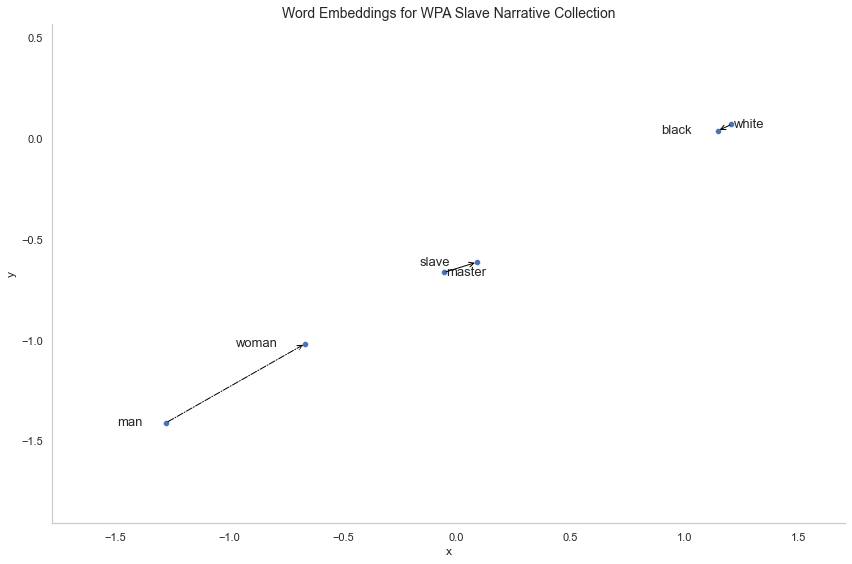

In [364]:
set_seaborn_style()
plt.figure(figsize=(12,8))
word_plot = sns.scatterplot(data=df,x='x',y='y')
word_plot.grid(False)
word_plot.set_xlim(xlim)
word_plot.set_ylim(ylim)
sns.despine(bottom=False, left=False, right=True, top=True)
#word_plot.set_xticks([])
#word_plot.set_yticks([])
word_plot.set_title("Word Embeddings for WPA Slave Narrative Collection", fontdict={'size':14})
hptutil.label_points(df['x'], df['y'], df['token'], plt.gca(), x_offset=0.01, adjustments=label_adj)
# Line from white to black
hptutil.draw_arrow(df, "white", "black", astyle="->")
hptutil.draw_arrow(df, "master", "slave", astyle="->")
#draw_arrow(df, "free", "prison")
hptutil.draw_arrow(
    df, "man", "woman",
    #lstyle="--"
    #lstyle=":"
    lstyle="-."
)
#plt.arrow(0.99,1.76,1,1,width=0.01,head_width=0.1,head_length=0.1,length_includes_head=True,color='black')
#plt.annotate("", xy=(0.99, 1.76), xytext=(1.96, -0.45), arrowprops=dict(arrowstyle="->",color='black'))
plt.tight_layout()
svg_fpath = os.path.join(fig_path, "wpa_embeddings.svg")
plt.savefig(svg_fpath)

Export to latex

In [365]:
import numpy as np


In [366]:
np.floor(3.95*2)/2

3.5

In [367]:
# For exporting
import hptutil
import pyperclip
tex_str = hptutil.custom_latex_export(df, self_contained=True)
pyperclip.copy(tex_str)
tex_output_fpath = os.path.join("wpa_embeddings.tex")
with open(tex_output_fpath, 'w', encoding='utf-8') as outfile:
    outfile.write(tex_str)

AttributeError: 'int' object has no attribute 'replace'

## tSNE?

In [527]:
wpa_model_lowwin.wv.similar_by_word("woman", topn=50)

[('child', 0.5919786095619202),
 ('man', 0.5781062841415405),
 ('master', 0.4575720727443695),
 ('married', 0.43151068687438965),
 ('maid', 0.4069543778896332),
 ('baby', 0.39265432953834534),
 ('parent', 0.38455986976623535),
 ('slave', 0.3825269341468811),
 ('said', 0.3791113793849945),
 ('ann', 0.36679261922836304),
 ('house', 0.3632958233356476),
 ('missis', 0.3620837926864624),
 ('mary', 0.3445001244544983),
 ('died', 0.3439081907272339),
 ('jenny', 0.34306690096855164),
 ('told', 0.3369848132133484),
 ('home', 0.3277442157268524),
 ('helen', 0.32448846101760864),
 ('bob', 0.32343441247940063),
 ('jane', 0.3223210871219635),
 ('stepmother', 0.3196958899497986),
 ('agnes', 0.3134170174598694),
 ('jennie', 0.3118191659450531),
 ('elizabeth', 0.3087044656276703),
 ('glover', 0.3072133958339691),
 ('holloway', 0.30481114983558655),
 ('nursed', 0.30372655391693115),
 ('named', 0.30143967270851135),
 ('caline', 0.3001418709754944),
 ('watt', 0.2994087040424347),
 ('liza', 0.299275606870

In [565]:
tsne_vecs = wpa_model_lowwin.wv.vectors
tsne_vecs_normed = wpa_model_lowwin.wv.get_normed_vectors()
# Change this to change whether it uses normed vectors
tsne_vec_df = pd.DataFrame(tsne_vecs_normed, index=wpa_model_lowwin.wv.index_to_key)
tsne_vec_df

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
man,-0.024347,-0.004725,-0.120339,0.120782,-0.008286,0.007918,-0.010505,-0.055593,0.007615,0.068271,...,0.062661,0.067812,0.027821,0.100650,-0.014027,-0.040721,-0.043042,-0.039209,0.027667,-0.023360
woman,-0.045522,0.034359,-0.013369,0.104836,0.001990,0.071862,-0.015627,-0.063905,-0.067665,0.076852,...,0.058851,-0.002069,0.030597,0.054980,0.000095,-0.088552,-0.056883,-0.015013,0.046478,0.015003
master,0.042024,0.023527,-0.064536,0.048670,0.037455,0.088375,-0.012952,-0.004329,0.084342,-0.007309,...,-0.041947,0.061965,0.024182,0.023347,-0.083071,-0.098331,-0.113994,-0.066312,0.016210,-0.004146
black,-0.056924,0.030544,-0.053184,0.127622,-0.013498,-0.002311,0.045347,-0.116191,-0.004609,-0.003211,...,0.010241,0.115435,-0.043891,0.051234,-0.239777,0.047615,-0.010026,-0.050618,0.026481,-0.028326
slave,-0.037377,0.063101,-0.050927,0.148749,-0.005549,0.029721,-0.047312,-0.029264,0.002360,-0.027083,...,0.021453,0.005530,-0.090473,0.051140,-0.111808,-0.026015,-0.056768,-0.018440,-0.028151,-0.047007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
completely,-0.030439,0.016018,-0.007473,-0.007417,-0.035213,-0.124430,-0.032784,-0.070512,-0.034526,-0.048004,...,-0.059431,0.012857,-0.150712,-0.138252,0.071577,0.003334,-0.000021,0.009923,-0.030798,0.012241
bettah,0.050995,-0.030078,0.121030,-0.015310,-0.054650,-0.108518,-0.009040,0.057482,0.065739,-0.047732,...,0.085530,0.118664,0.029980,0.071756,0.016228,0.006673,0.003767,-0.049010,0.079990,0.127538
discharged,0.069652,0.054548,-0.020361,-0.027295,-0.086826,-0.038191,0.043286,0.074811,0.057368,0.015553,...,0.032169,0.008422,-0.066750,0.076389,0.017266,0.027900,-0.063775,-0.018018,0.059663,-0.024791
howsomeever,0.012540,0.006971,0.033983,-0.048163,0.076838,0.042620,0.004138,0.056808,-0.030205,-0.028744,...,-0.045014,0.074262,0.145893,-0.004466,0.020933,-0.050551,-0.069383,-0.061592,0.032779,-0.057461


### Select only top N

In [566]:
tsne_N = 1500
top_n_tokens = [t[0] for t in tcounts[:tsne_N]]
tsne_topn_df = tsne_vec_df[tsne_vec_df.index.isin(top_n_tokens)].copy()
tsne_topn_df

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
man,-0.024347,-0.004725,-0.120339,0.120782,-0.008286,0.007918,-0.010505,-0.055593,0.007615,0.068271,...,0.062661,0.067812,0.027821,0.100650,-0.014027,-0.040721,-0.043042,-0.039209,0.027667,-0.023360
woman,-0.045522,0.034359,-0.013369,0.104836,0.001990,0.071862,-0.015627,-0.063905,-0.067665,0.076852,...,0.058851,-0.002069,0.030597,0.054980,0.000095,-0.088552,-0.056883,-0.015013,0.046478,0.015003
master,0.042024,0.023527,-0.064536,0.048670,0.037455,0.088375,-0.012952,-0.004329,0.084342,-0.007309,...,-0.041947,0.061965,0.024182,0.023347,-0.083071,-0.098331,-0.113994,-0.066312,0.016210,-0.004146
black,-0.056924,0.030544,-0.053184,0.127622,-0.013498,-0.002311,0.045347,-0.116191,-0.004609,-0.003211,...,0.010241,0.115435,-0.043891,0.051234,-0.239777,0.047615,-0.010026,-0.050618,0.026481,-0.028326
slave,-0.037377,0.063101,-0.050927,0.148749,-0.005549,0.029721,-0.047312,-0.029264,0.002360,-0.027083,...,0.021453,0.005530,-0.090473,0.051140,-0.111808,-0.026015,-0.056768,-0.018440,-0.028151,-0.047007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
favorite,0.072344,-0.072158,0.101329,0.043580,-0.031839,-0.081449,-0.016637,0.118836,-0.074948,-0.050258,...,0.016393,-0.061320,0.044997,-0.056605,-0.023182,0.041495,0.008984,0.018820,-0.014391,0.032768
fokes,0.020241,-0.043081,-0.004712,0.019295,-0.004561,-0.078570,-0.021620,0.000927,0.018454,-0.052332,...,-0.074986,0.145136,0.082082,-0.100023,0.026812,-0.024569,0.019866,-0.067531,0.028885,0.026503
hants,0.046777,0.034870,0.039314,0.006232,0.033009,-0.048230,0.104678,-0.023733,0.156169,-0.081196,...,-0.050463,0.145219,0.116249,0.000108,0.017882,-0.072861,-0.009332,-0.015655,-0.053196,0.067778
poured,0.011887,0.068121,0.054373,-0.020440,-0.075791,-0.026620,0.062161,0.018921,0.032022,-0.053718,...,-0.031001,0.050824,-0.115299,0.007816,0.025906,0.090295,-0.027485,0.080941,-0.015574,-0.071942


In [567]:
from sklearn.manifold import TSNE

In [568]:
tsne = TSNE(n_components=2, random_state=global_seed,
            metric='cosine',
            learning_rate=10,
            perplexity=12.0, n_jobs=8,
            n_iter=2000)

In [569]:
#timeit -r1 -n1
# Project the data in 2D
#X_tsne = tsne.fit_transform(wpa_vecs)

# Convert df to just nunmeric matrix
#X_wpa_kw = wpa_kw_df.drop(columns=['token'])
X_tsne_topn = tsne.fit_transform(tsne_topn_df)

C:\Users\jpjac\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


In [570]:
tsne_df_full = pd.DataFrame(X_tsne_topn, columns=['x','y'], index=tsne_topn_df.index)

In [571]:
tsne_df_full

,x,y
man,49.130730,-5.986299
woman,52.736378,-3.596569
master,48.956425,-5.022352
black,43.699055,3.669152
slave,41.865707,1.229673
...,...,...
favorite,20.394947,-4.748906
fokes,43.251450,8.398065
hants,27.548153,19.711874
poured,-51.650932,-3.986603


In [594]:
# Now just the keywords
kw_remove = ['freedom', 'slavery']
kw_filtered = [kw for kw in kw_tsne if kw not in kw_remove]
#kw_add = ['plantation', 'rich', 'poor', 'child']
kw_add = ['baby', 'child', 'rich', 'poor']
kw_final = kw_filtered + kw_add
tsne_df = tsne_df_full[tsne_df_full.index.isin(kw_final)].copy()

In [595]:
tsne_df

,x,y
man,49.130730,-5.986299
woman,52.736378,-3.596569
master,48.956425,-5.022352
black,43.699055,3.669152
slave,41.865707,1.229673
white,44.269779,3.347187
child,51.684898,0.012143
baby,53.332302,-0.387958
poor,44.857105,39.364120
rich,48.930008,-22.436296


In [596]:
tsne_xmin = tsne_df['x'].min()
tsne_xmax = tsne_df['x'].max()
tsne_xrange = tsne_xmax - tsne_xmin
tsne_xpad = 0.01*tsne_xrange
tsne_xlim = (tsne_xmin - tsne_xpad, tsne_xmax + tsne_xpad)
# y
tsne_ymin = tsne_df['y'].min()
tsne_ymax = tsne_df['y'].max()
tsne_yrange = tsne_ymax - tsne_ymin
tsne_ypad = 0.01*tsne_yrange
tsne_ylim = (tsne_ymin - tsne_ypad, tsne_ymax + tsne_ypad)

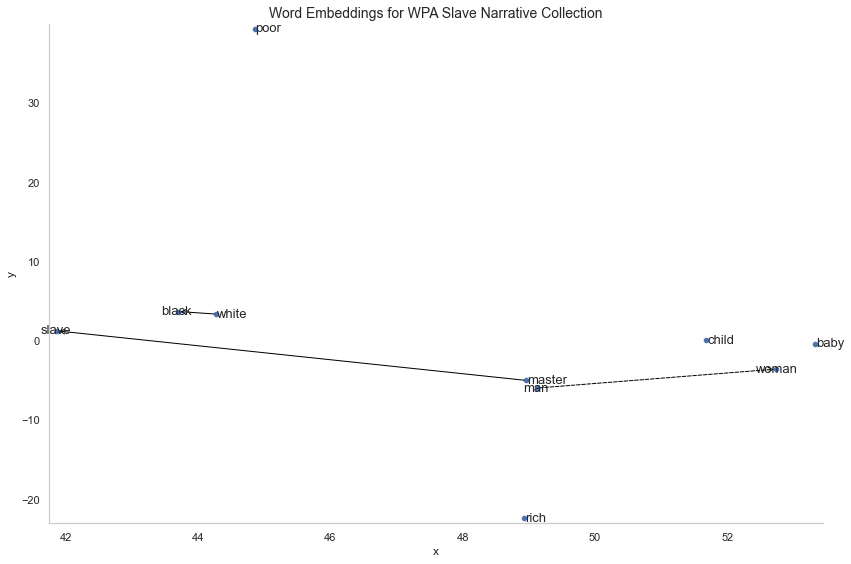

In [597]:
# Plot tSNE like it's the 2d space
set_seaborn_style()
plt.figure(figsize=(12,8))
word_plot = sns.scatterplot(data=tsne_df,x='x',y='y')
word_plot.grid(False)
word_plot.set_xlim(tsne_xlim)
word_plot.set_ylim(tsne_ylim)
sns.despine(bottom=False, left=False, right=True, top=True)
#word_plot.set_xticks([])
#word_plot.set_yticks([])
# Line from white to black
hptutil.draw_arrow(tsne_df, "white", "black")
hptutil.draw_arrow(tsne_df, "master", "slave")
hptutil.draw_arrow(tsne_df, "man", "woman", lstyle="--")
#plt.arrow(0.99,1.76,1,1,width=0.01,head_width=0.1,head_length=0.1,length_includes_head=True,color='black')
#plt.annotate("", xy=(0.99, 1.76), xytext=(1.96, -0.45), arrowprops=dict(arrowstyle="->",color='black'))
word_plot.set_title("Word Embeddings for WPA Slave Narrative Collection", fontdict={'size':14})
hptutil.label_points(tsne_df['x'], tsne_df['y'], tsne_df.index, plt.gca(), x_offset=0.01, adjustments=label_adj)
plt.tight_layout()

In [598]:
tsne_df.loc['poor','y']

39.36412

In [599]:
# Just rescaling the poor/rich, since they're so far away in the y direction you can't
# see the angles in the plot
tsne_df.at['poor','y'] = tsne_df.loc['poor', 'y'] / 3
tsne_df.at['rich','y'] = tsne_df.loc['rich', 'y'] / 3

In [600]:
# Trying this...
#logx_df = tsne_df.copy()
#logx_df['x'] = logx_df['x'].apply(np.log)
##logx_df['y'] = log_df['y'].apply(np.log)
#logx_df

In [606]:
# To latex
tex_arrows = [
    ('man', 'woman', 'dashed'),
    ('master', 'slave', ''),
    ('white', 'black', ''),
]
label_data = {
    'slave': {'anchor': 'south', 'xshift': 0.0, 'yshift': 0.0},
    'black': {'anchor': 'south'},
    'master': {'anchor': 'south', 'xshift': 8.0, 'yshift': 2.0},
    'woman': {'anchor': 'north', 'xshift': 2.0, 'yshift': -4.0}
}
# Self-contained version
tsne_tex_standalone = hptutil.custom_latex_export(tsne_df, label_data=label_data, arrows=tex_arrows,
                                       self_contained=True, pad_pct=0.1)
tex_standalone_fpath = "./tsne_standalone.tex"
with open(tex_standalone_fpath, 'w', encoding='utf-8') as outfile:
    outfile.write(tsne_tex_standalone)
# Version for paper
tsne_tex = hptutil.custom_latex_export(tsne_df, label_data=label_data, arrows=tex_arrows,
                                                  self_contained=False, pad_pct=0.1)
tex_output_fpath = os.path.join(fig_path, "wpa_tsne_morewords.tex")
with open(tex_output_fpath, 'w', encoding='utf-8') as outfile:
    outfile.write(tsne_tex)

[Arrow()] self.dash_str = dashed,
[Arrow()] self.dash_str = 
[Arrow()] self.dash_str = 
[Arrow()] self.dash_str = dashed,
[Arrow()] self.dash_str = 
[Arrow()] self.dash_str = 


## Wordcloud...

In [592]:

tcounts_filtered = [t for t in tcounts if t[0] not in wc_stopwords]
print(tcounts_filtered, end="")

NameError: name 'wc_stopwords' is not defined

In [593]:
all_tokens_str = " ".join([t[0] for t in tcounts_filtered])

NameError: name 'tcounts_filtered' is not defined

In [84]:
# Libraries
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create a list of word

# Create the wordcloud object
wordcloud = WordCloud(width=1200, height=1200, margin=0).generate(all_tokens_str)

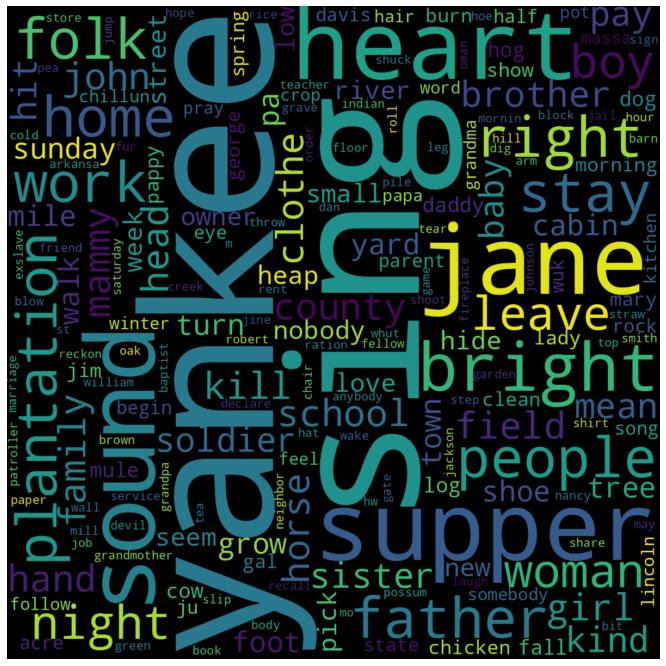

In [85]:
# Display the generated image:
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

### For export to Colab

In [37]:
#full_df = get_embedding_df(wpa_model_lowdim, keywords_full)
#full_df = get_embedding_df(wpa_model, keywords_full)

In [38]:
wpa_vecs = []
for cur_kw in kw_full:
    cur_vec = wpa_model.wv[cur_kw]
    wpa_vecs.append([cur_kw, cur_vec])

In [39]:
#full_df.to_pickle("wpa_2d_df.pkl", protocol=4)
joblib.dump(wpa_vecs, "wpa_vecs.pkl")

['wpa_vecs.pkl']

In [40]:
!pip install whatlies[umap]
!pip install --upgrade gensim

  Using cached whatlies-0.7.0-py2.py3-none-any.whl (84 kB)
  Using cached bpemb-0.3.4-py3-none-any.whl (19 kB)
  Using cached altair-4.2.2-py3-none-any.whl (813 kB)
  Using cached gensim-3.8.3.tar.gz (23.4 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached umap_learn-0.5.3-py3-none-any.whl
  Using cached pynndescent-0.5.8-py3-none-any.whl
  Running setup.py clean for gensim
Failed to build gensim
  Attempting uninstall: gensim
    Found existing installation: gensim 4.3.1
    Uninstalling gensim-4.3.1:
      Successfully uninstalled gensim-4.3.1
  Running setup.py install for gensim: started
  Running setup.py install for gensim: finished with status 'error'
  Rolling back uninstall of gensim
  Moving to c:\users\jpjac\lib\site-packages\gensim-4.3.1.dist-info\
   from C:\Users\jpjac\Lib\site-packages\~ensim-4.3.1.dist-info
  Moving to c:\users\jpjac\lib\site-packages\gensim\
   from C:\Users\jpjac\Lib\site-packages\~

  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [476 lines of output]
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-3.10
  creating build\lib.win-amd64-3.10\gensim
  copying gensim\downloader.py -> build\lib.win-amd64-3.10\gensim
  copying gensim\interfaces.py -> build\lib.win-amd64-3.10\gensim
  copying gensim\matutils.py -> build\lib.win-amd64-3.10\gensim
  copying gensim\nosy.py -> build\lib.win-amd64-3.10\gensim
  copying gensim\utils.py -> build\lib.win-amd64-3.10\gensim
  copying gensim\__init__.py -> build\lib.win-amd64-3.10\gensim
  creating build\lib.win-amd64-3.10\gensim\corpora
  copying gensim\corpora\bleicorpus.py -> build\lib.win-amd64-3.10\gensim\corpora
  copying gensim\corpora\csvcorpus.py -> build\lib.win-amd64-3.10\gensim\corpora
  copying gensim\corpora\dictionary.py -> build\lib.win-amd64-3.10\gensim\corpora
  copying gensim\corpora\hashdi


[notice] A new release of pip available: 22.3.1 -> 23.1
[notice] To update, run: python.exe -m pip install --upgrade pip
